<a href="https://colab.research.google.com/github/arnavrast/pyCboc/blob/master/Santander_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [ ]:
#!pip install kaggle
!pip install scikit-learn==0.23.1
!pip install scikit-optimize
!pip install pymrmre
!mkdir $HOME/.kaggle
from google.colab import files
uploaded = files.upload()

In [ ]:
!mv kaggle.json $HOME/.kaggle/kaggle.json
!chmod 600 $HOME/.kaggle/kaggle.json
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!kaggle competitions download -c santander-value-prediction-challenge

# **The Challenge**


According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

$$\epsilon=\sqrt{\frac{1}{n}\sum_{i=1}^{n}[log(p_i+1)-log(a_i+1)]^2}$$
Where:

\\(\epsilon\\) is the RMSLE value (score)

\\(n\\) is the total number of observations in the (public/private) data set,

\\(p_i\\) is your prediction of target, and

\\(a_i\\) is the actual target for \\(i\\).

\\(\log(x)\\) is the natural logarithm of \\(x\\)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import csr_matrix

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn import random_projection
from lightgbm import LGBMRegressor
from sklearn.preprocessing import FunctionTransformer,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.metrics import make_scorer,mean_squared_error
from pymrmre import mrmr

import gc
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import *
InteractiveShell.ast_node_interactivity = "all"

In [3]:
train= pd.read_csv('/content/train.csv.zip')
test=pd.read_csv('/content/test.csv.zip')

In [4]:
print('\n Shape = ',train.shape) #,test.shape
train.info()
train.describe()


 Shape =  (4459, 4993)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,...,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00,4459.00
mean,5944923.32,14654.93,1390.89,26722.45,4530.16,26409.96,30708.11,16865.22,4669.21,2569407.37,155215.84,195050.00,8.52,3595.87,2258014.80,268084.32,45882.55,44514.78,396896.09,28831.29,1940.79,448384.09,79897.29,154839.43,112825.36,114832.92,3377.44,0.00,379413.01,120224.71,742646.40,4994.84,1725258.22,194188.17,0.00,93383.27,629689.62,0.00,1249545.29,1200041.53,...,2412.20,376758.91,666947.78,42819.49,6.28,140911.19,236477.99,762748.51,675263.96,542865.36,777697.87,100485.12,382502.49,2539.58,3767.66,41538.91,70412.24,96485.62,975124.02,29109.67,75998.02,3588.25,179601.61,530280.99,237739.63,1183135.48,1247793.15,986.77,61650.15,128949.46,467605.70,444623.94,805621.95,781296.64,143.53,121380.93,35734.51,312374.07,92199.60,227909.96
std,8234311.50,389329.81,64283.02,569965.18,235912.41,1514730.15,577058.97,751275.59,187944.89,9610183.07,1587814.71,2397372.09,569.07,124543.50,15522980.13,3026909.74,814067.36,1354504.11,3238242.60,570538.76,27860.22,6370643.86,2846439.90,2425793.87,1161274.59,2747534.58,131383.85,0.00,3561409.05,4867502.88,3799941.04,186866.36,9034308.14,1481349.06,0.00,854776.37,6956379.91,0.00,7361172.67,8113234.07,...,149858.56,7755050.84,6261372.65,547336.96,322.56,2052878.49,1533061.99,5816721.55,7444468.36,4250171.64,4287642.81,915006.75,2799847.78,150868.32,251588.36,1179500.40,2810829.54,1114863.17,9750283.16,791206.38,1206580.86,239607.96,1660884.12,4497566.80,4109064.67,11394925.26,6878894.51,65892.19,2124731.41,1335938.24,4068037.55,4428889.45,4513245.79,6839450.76,9584.32,4720708.53,1614622.20,4318500.71,1635993.43,1811139.28
min,30000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,600000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2260000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [5]:
ID=train.pop('ID')

In [6]:
train_stat = train.agg(['nunique','sum','var','kurtosis','std','min','max','skew']).T
train_stat['Null']=train.isnull().sum()
train_stat['Zeros']=(train==0).sum()
train_stat['Duplicated']=train.T.duplicated()
train_stat['Missing']=1.0*train_stat.Zeros/train.shape[0]

In [7]:
print('Null Values:',train_stat.Null.sum())
print('Zero Values:',train_stat.Zeros.sum())
print('Constant Valued Columns:',np.sum(train_stat['nunique']==1))
print('Zeroed Valued Columns:',len(train_stat[train_stat.Zeros==train.shape[0]]))
print('Duplicated Columns:',train_stat['Duplicated'].sum())

Null Values: 0
Zero Values: 21554760
Constant Valued Columns: 256
Zeroed Valued Columns: 256
Duplicated Columns: 260


In [8]:
HTML('<p>The dataset has <b>'+str(np.sum(train.duplicated()))+' duplicate</b> Records.')

#Sparsity and other characteristics

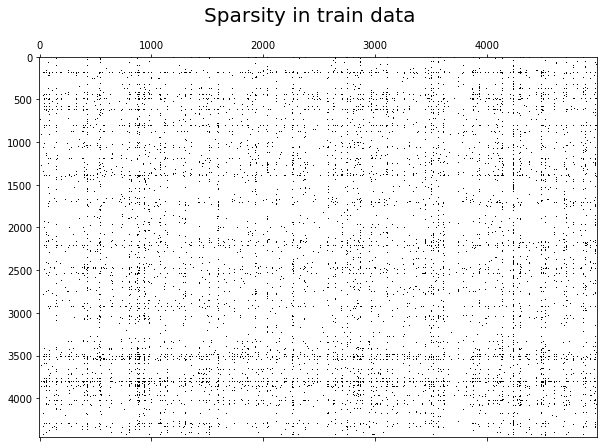

In [9]:
plt.figure(figsize=(10,7));
plt.spy(train,aspect='auto');
plt.suptitle('Sparsity in train data',fontsize=20);

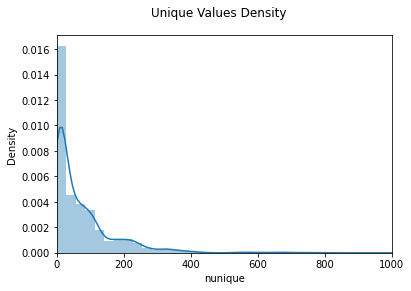

In [10]:
sns.distplot(train_stat['nunique']);
plt.xlim(0,1000);
plt.suptitle('Unique Values Density');

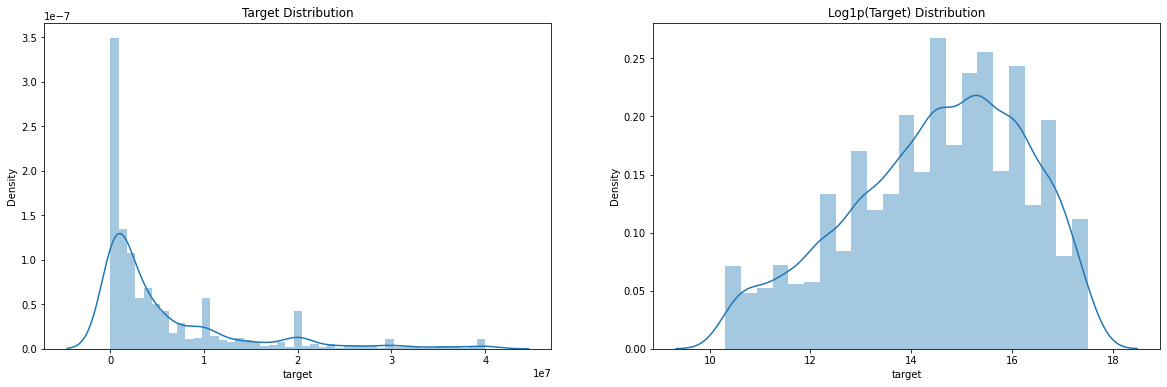

In [11]:
fig, axs = plt.subplots(1,2,figsize=(20,6))
sns.distplot(train.target,ax=axs[0]);
sns.distplot(np.log1p(train.target),ax=axs[1]);
axs[0].title.set_text('Target Distribution');
axs[1].title.set_text('Log1p(Target) Distribution');

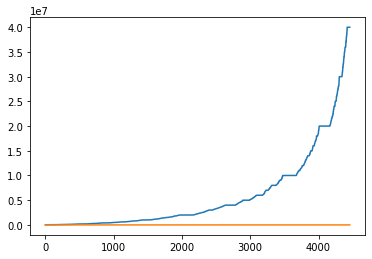

In [12]:
sns.lineplot(data=train ,x=range(train.shape[0]), y=np.sort(train.target));
sns.lineplot(data=train ,x=range(train.shape[0]), y=np.sort(np.log1p(train.target)));

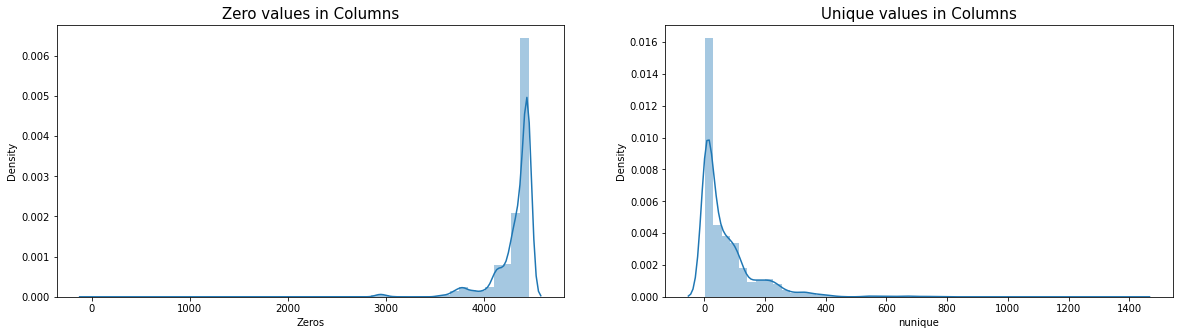

In [13]:
f,ax= plt.subplots(1,2,figsize=(20,5));
sns.distplot(train_stat.Zeros,ax=ax[0]);
sns.distplot(train_stat['nunique'],ax=ax[1]);
ax[0].set_title('Zero values in Columns',fontsize=15);
ax[1].set_title('Unique values in Columns',fontsize=15);

# **Feature Selection & Engineering**

In [14]:
dup_cols = train.columns[train.T.duplicated()]
const_cols=train.columns[train.nunique()==1]
cols_to_remove = dup_cols.append(const_cols).unique()
train.drop(columns=cols_to_remove,inplace=True)

In [15]:
X = train.copy()
Y= pd.DataFrame(np.log1p(X.pop('target')),index=train.index)
X = pd.DataFrame(FunctionTransformer(np.sqrt).fit_transform(X),columns=X.columns,index=X.index)
X = pd.DataFrame(MinMaxScaler().fit_transform(X),columns=X.columns,index=X.index)
solutions = mrmr.mrmr_ensemble(features=X,targets=Y,solution_length=50,solution_count=1)
feat_mrmr=solutions[0][0]
X_freg= SelectKBest(f_regression,k=50).fit(X,Y)
feat_freg=X_freg.get_support()
feat_freg = X.columns[feat_freg]

In [16]:
X_mut= SelectKBest(mutual_info_regression,k=50).fit(csr_matrix(X),Y)
feat_mut=X_mut.get_support()
feat_mut = X.columns[feat_mut]
feat_final = feat_mut.append(pd.Index(feat_mrmr)).append(feat_freg).unique() #.append(pd.Index(['9306da53f','fb0f5dbfe']))

In [17]:
def stat_cols(df):
  weight = ((df != 0).sum()/len(df)).values
  df1 = pd.DataFrame()
  df_tmp= df[df!=0]
  df1["sum"] = df.sum(axis=1)
  df1["Values"]=(df!=0).sum(axis=1)
  df1["weight_count"] = (df_tmp*weight).sum(axis=1)
  df1["Variance_NonZero"]=df_tmp.var(axis=1)
  df1["Mean_NonZero"]=df_tmp.mean(axis=1)
  df1["Median_NonZero"]=df_tmp.median(axis=1)
  df1["Std_Dev_NonZero"]=df_tmp.std(axis=1)
  df1["Skew_NonZero"]=df_tmp.skew(axis=1)
  df1["Kurt_NonZero"]=df_tmp.kurtosis(axis=1)
  df1["Max_NonZero"]=df_tmp.max(axis=1)
  df1["Min_NonZero"]=df_tmp.min(axis=1)
  del df_tmp
  gc.collect()
  return df1

def proj_cols(df,n_dim):
  r= random_projection.SparseRandomProjection(n_components=n_dim)
  return pd.DataFrame(r.fit_transform(df)),r

In [18]:
reg=LGBMRegressor(objective='regression_l2',n_jobs=-1,metric='rmse',verbosity=-1,boosting='gbdt')
params = {
        'n_estimators': Integer(50, 100),  
        'num_leaves':   Integer(5,100),     
        'min_child_samples': Integer(1, 50), 
        'feature_fraction': Real(0.1, 0.8),
        'max_depth' : Integer(1, 50),
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'scale_pos_weight': Real(1, 10),
        'max_bin': Integer(100, 1000),        
        'min_child_weight': Real(1, 10),      
        'subsample_for_bin': Integer(100, 3000)  
        }


In [19]:
bayes_cv_tuner = BayesSearchCV(
                              estimator = reg,
                              search_spaces = params,
                              cv = 3,
                              #scoring = custom_rmsle,
                              n_jobs = 3,
                              n_iter = 25,
                              verbose = 1,
                              random_state = 42
                               )

In [20]:
X = train.copy()[feat_final]
rp,r=proj_cols(train,127)
ft=FunctionTransformer(np.sqrt).fit(X)
X_ = pd.DataFrame(ft.transform(X),columns=X.columns)
X_ =pd.concat([X_,stat_cols(train).reset_index(),rp],axis=1)
minmax = MinMaxScaler().fit(X_)
X_ = minmax.transform(X_)

#X_ =pd.concat([pd.DataFrame(X_,columns=X.columns).reset_index().drop(columns=['index']),df1.reset_index().drop(columns=['ID']),rp.reset_index().drop(columns=['ID'])],axis=1)
X_=csr_matrix(X_)
y=np.log1p(train.target)

result= bayes_cv_tuner.fit(X_,y)
print(bayes_cv_tuner.best_params_)
print("Best Score = ",np.round(bayes_cv_tuner.best_score_, 4))

bst_stat = bayes_cv_tuner.best_estimator_
bst_stat 
np.sqrt(mean_squared_error(y,bst_stat.predict(X_)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


OrderedDict([('feature_fraction', 0.6596874091250212), ('learning_rate', 0.07517239253342656), ('max_bin', 574), ('max_depth', 36), ('min_child_samples', 45), ('min_child_weight', 7.453280360438533), ('n_estimators', 71), ('num_leaves', 67), ('reg_lambda', 1.725862317016256e-05), ('scale_pos_weight', 6.934836058291866), ('subsample_for_bin', 1588)])
Best Score =  0.8201


LGBMRegressor(boosting='gbdt', feature_fraction=0.6596874091250212,
              learning_rate=0.07517239253342656, max_bin=574, max_depth=36,
              metric='rmse', min_child_samples=45,
              min_child_weight=7.453280360438533, n_estimators=71,
              num_leaves=67, objective='regression_l2',
              reg_lambda=1.725862317016256e-05,
              scale_pos_weight=6.934836058291866, subsample_for_bin=1588,
              verbosity=-1)

0.36380072083274534

In [21]:
r
ft
minmax

SparseRandomProjection(n_components=127)

FunctionTransformer(func=<ufunc 'sqrt'>)

MinMaxScaler()

In [ ]:
#test.drop(columns=cols_to_remove,inplace=True)
X = test[feat_final]
rp,r1=proj_cols(X,127)
X_ = pd.DataFrame(ft.transform(X),columns=X.columns)
X_ =pd.concat([X_,stat_cols(test.drop(columns=['ID'])).reset_index(),rp],axis=1)
X_ = minmax.transform(X_)
X_=csr_matrix(X_)
test['target']=np.expm1(bayes_stat.predict(X_test))
test[['ID', 'target']].to_csv('submission_rp_ft_bayes_lgb.csv', index=False, float_format='%.6f')